In [59]:
import matplotlib.pylab as plt   # That gives plotting, and the next line makes plots appear inline in notebook
%matplotlib inline  
import numpy as np  # That gives numerical arrays and tools for manipulating them

import scipy.optimize as opt
import scipy.linalg as la

## Crouse et al paper on loggerhead sea turtle population management

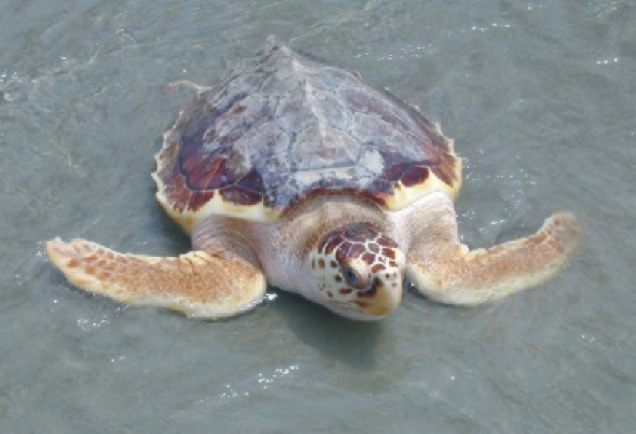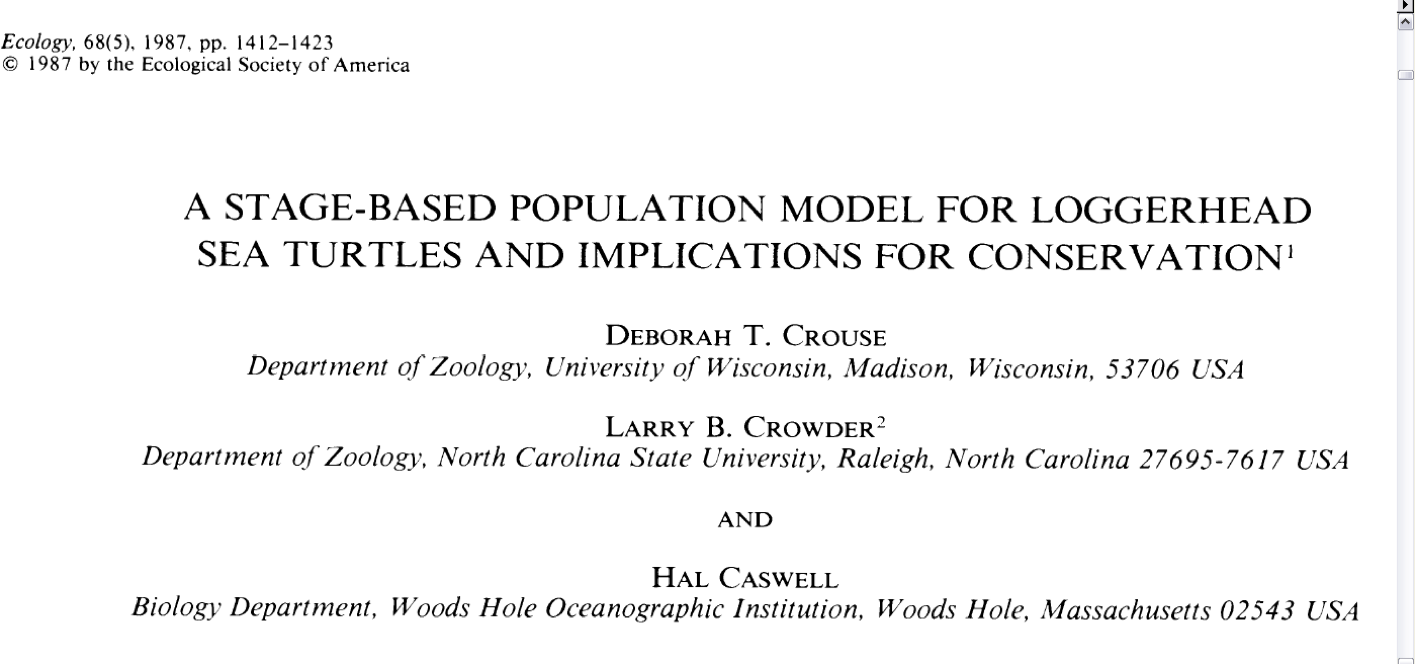

# Define projection matrix A

$$ A = \begin{pmatrix}P_1 & F_2 & F_3 & F_4 & F_5 & F_6 & F_7 \\
G_1 & P_2 & 0 & 0 & 0 &0 & 0 \\
0 & G_2 & P_3 & 0 & 0 &0 & 0 \\
0 & 0 & G_3 & P_4 & 0 &0 & 0 \\
0 & 0 & 0 & G_4 & P_5 &0 & 0 \\
0 & 0 & 0 & 0 & G_5 &P_6 & 0 \\
0 & 0 & 0 & 0 & 0 &G_6 & P_7 \\
\end{pmatrix}$$

$$G_i = \text{fraction of stage $i$ population that survives and grows into stage $i+1$}$$

$$P_i = \text{fraction of stage $i$ population that survives stays in stage $i$} $$

Let $p_i$ denote the one-year probability of survival for stage $i$, and let $d_i$ denote the duration (in years) of stage $i$. Then (under some simplifying assumptions about the make-up of each stage):
$$
P_i = p_i \frac{1- p_i^{d_i-1}}{1-p_i^{d_i}}, \quad G_i = p_i^{d_i} \frac{1-p_i}{1-p_i^{d_i}}.
$$
Interpretation? Can think in terms of conditional probabilities:
$$
\gamma_i = P(\text{stage $i$ to $i+1$} | \text{survive}) = \text{proportion of oldest individuals in stage $i$} = \frac{p_i^{d_i-1}}{1+p_i+p_i^2 +\dots+p_i^{d_i-1}} = p_i^{d_i-1}\frac{1-p_i}{1-p_i^{d_i}}
$$
Then $G_i = p_i \gamma_i$ and $P_i = p_i(1-\gamma_i)$.

#### Projection matrix from Table 4:

In [64]:
A=np.array([
    [ 0,    0,     0,     0,    127,       4,   80],  
 [.6747,  .737,   0,     0,     0,         0,    0], 
 [   0 , .0486 , .661,    0,     0,         0,    0],  
 [   0 ,    0 , .0147 ,  .6907 ,  0 ,     0  ,  0 ],
 [   0 ,    0 ,   0   , .0518 ,    0 ,     0  ,  0 ],
 [   0 ,    0 ,   0  ,   0  ,  .8091   ,   0  ,  0 ] ,
 [   0 ,    0  ,  0  ,   0  ,   0    ,   .8091 , .8089  ]])

#### Projection matrix construction from life table:

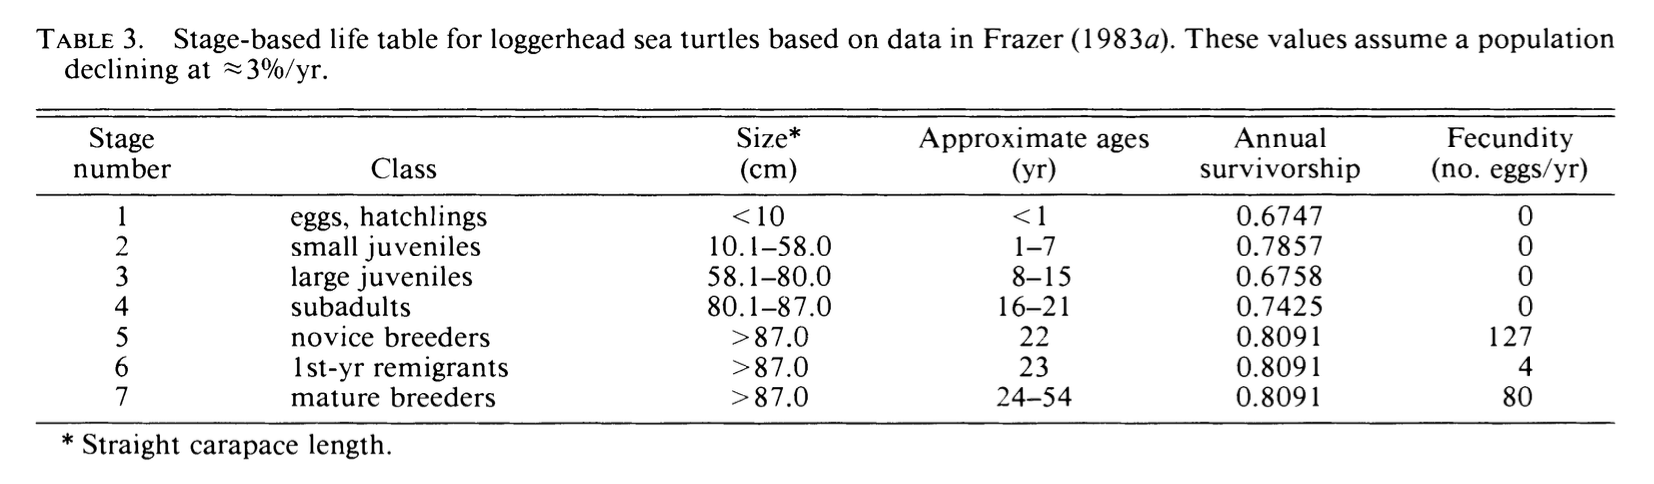

In [65]:
d = np.array([1,7,8,6,1,1,31])
p = np.array([0.6747,0.7857,0.6758,0.7425,0.8091,0.8091,0.8091])
F = np.array([0,0,0,0,127,4,80])
P = np.zeros(7)
G = np.zeros(6)

#### Breakout: 5-10 mins

Using the formulas provided above, construct the projection matrix for the loggerhead model

In [66]:
for i in range(7):
    P[i] = p[i] * (1 - p[i] ** (d[i] - 1)) / (1 - p[i] ** d[i])
    if i < 6:
        G[i] = (p[i] ** d[i]) * (1 - p[i]) / (1 - p[i] ** d[i])

Anew = np.zeros((7, 7))
for i in range(7):
    Anew[i, i] = P[i]
    if i > 0:
        Anew[0, i] = F[i]
    if i < 6:
        Anew[i+1, i] = G[i]

np.set_printoptions(threshold=np.inf)
print(Anew)


[[  0.       0.       0.       0.     127.       4.      80.    ]
 [  0.6747   0.7371   0.       0.       0.       0.       0.    ]
 [  0.       0.0486   0.6611   0.       0.       0.       0.    ]
 [  0.       0.       0.0147   0.6907   0.       0.       0.    ]
 [  0.       0.       0.       0.0518   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.8091   0.       0.    ]
 [  0.       0.       0.       0.       0.       0.8091   0.8088]]


Check that this matrix agrees with $A$ as directly typed in from Table 4:

In [67]:
print(A - Anew)

[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.0001  0.      0.      0.      0.      0.    ]
 [ 0.      0.     -0.0001  0.      0.      0.      0.    ]
 [ 0.      0.     -0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.0001]]


The projection matrix $A$ is non-negative, but it is NOT positive. Is it power positive?

#### Breakout: 5 mins

Find minimum $n$ such that $A^n >0$.

In [33]:
n=6
C = np.linalg.matrix_power(A,n) # compute A^n
print(C>0) # for every entry of C, prints 'True' if entry is > 0, 'False' if not

[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


From class: $A \in \mathbb{R}^{m\times m}$ is power positive iff $A^{m^2 - 2m +2}$ is positive. Check for loggerhead matrix (m=7):

In [34]:
m=A.shape[0] # A.shape = (m,m)
C = np.linalg.matrix_power(A,m**2 - 2*m + 2) # compute A^(m^2 - 2m + 2)
print(C>0) # for every entry of C prints 'True' if entry is > 0, 'False' if not

[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


### Compute eigenvalues

Based on A being power positive, Perron-Frobenius tells us that we will have a single, real positive dominant eigenvalue, and that's what we find:

In [35]:
l,v = la.eig(A) # l = array of eigenvalues, v = matrix (2D array) of eigenvectors (columns)

idx=np.argsort(np.abs(l)) # get indexes corresponding to smallest -> largest eigenvalue
l_sorted=l[idx] # rearrange eigenvalues in ascending order by magnitude
v_sorted=v[:,idx] # rearrange eigenvectors in same order
lambda_max= l_sorted[-1] # get eigenvalue with largest magnitude (dominant eigenvalue)
print(abs(l_sorted)) # print magnitudes of sorted eigenvalues
print(lambda_max) # print dominant eigenvalue

[0.1488 0.1488 0.2655 0.3717 0.776  0.776  0.945 ]
(0.9450309806910048+0j)


Looks like bad news ($|\lambda_1| < 1$ means population goes extinct), but let's simulate it!

In [36]:
Tmax=100

n_vs_t=np.zeros([7,Tmax])
n_zero=np.array([2900,9000,1600,100,5,4,20])
n_vs_t[:,0]=n_zero 

for t in np.arange(Tmax-1):
    n_vs_t[:,t+1]=np.dot(A,n_vs_t[:,t])


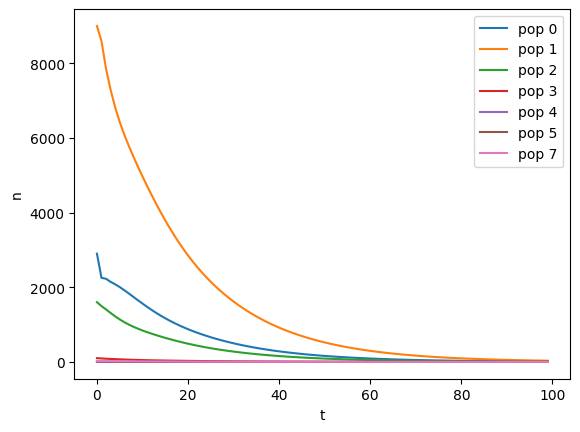

In [37]:
generation_arr=np.arange(Tmax)

plt.plot(generation_arr,n_vs_t[0,:],label="pop 0")
plt.plot(generation_arr,n_vs_t[1,:],label="pop 1")
plt.plot(generation_arr,n_vs_t[2,:],label="pop 2")
plt.plot(generation_arr,n_vs_t[3,:],label="pop 3")
plt.plot(generation_arr,n_vs_t[4,:],label="pop 4")
plt.plot(generation_arr,n_vs_t[5,:],label="pop 5")
plt.plot(generation_arr,n_vs_t[6,:],label="pop 7")
plt.xlabel('t')
plt.ylabel('n')
plt.legend()

## Need management plan:  what entries in A can we try to increase?


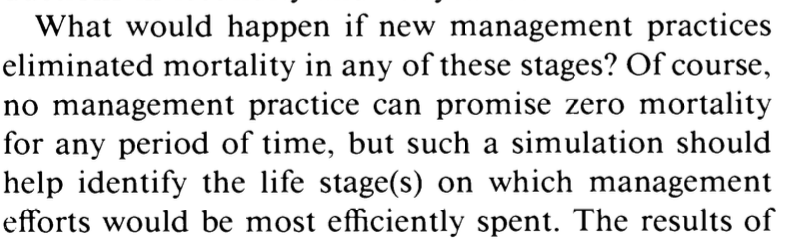

##### However...

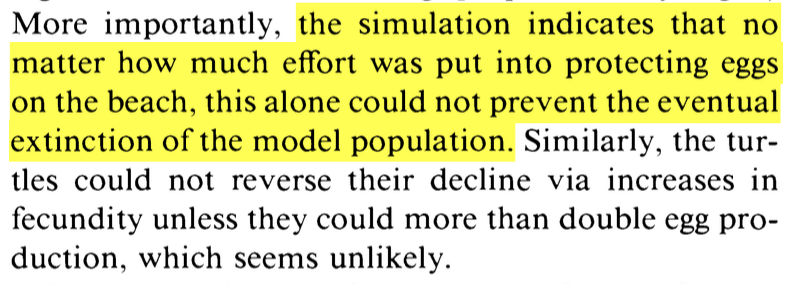

In [38]:
np.set_printoptions(precision=4,suppress=True)
print(A) # reprint A

[[  0.       0.       0.       0.     127.       4.      80.    ]
 [  0.6747   0.737    0.       0.       0.       0.       0.    ]
 [  0.       0.0486   0.661    0.       0.       0.       0.    ]
 [  0.       0.       0.0147   0.6907   0.       0.       0.    ]
 [  0.       0.       0.       0.0518   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.8091   0.       0.    ]
 [  0.       0.       0.       0.       0.       0.8091   0.8089]]


###  Compute eigenvalue sensitivites



First we will (re-) compute the dominant eigenvalue $\lambda_1$ and corresponding eigenvector $\mathbf{v}$ of A.  We already did this above, but will repeat the code so we have it all together here:

In [39]:
l,v = la.eig(A)

idx=np.argsort(np.abs(l))
l_sorted=l[idx]  
v_sorted=v[:,idx]   #rearrange eigenvectors in same order
lambda_max= l_sorted[-1]
v_max = v_sorted[:,-1]

Next we compute the eigenvalues and eigenvectors of $A^T$ (that is, A transpose). Recall that the eigenvalues of A and its transpose are the same. The corresponding eigenvectors of $A^T$ are also called the <i>left eigenvectors</i> of $A$ (lets denote them by $\mathbf{w}$).

In [40]:
l,w = la.eig(A.T)

idx=np.argsort(np.abs(l))
l_sorted=l[idx] # eigenvalues of A^T are the same as A - will give same sorting
w_sorted= w[:,idx] # rearrange left eigenvectors of A in same order
w_max = w_sorted[:,-1] # get left eigenvector corresponding to lambda_max

Now, the sensitivity $s_{ij}$ of $\lambda_1$ corresponding to entry $a_{ij}$ is $$ s_{ij} = \frac{ w_{i} v_j }{\mathbf{w} \cdot \mathbf{v} } = \frac{\partial \lambda_1}{\partial a_{ij}}$$

The numerator is the product of the $i$th entry of $\mathbf{w}$ and the $j$th entry of $\mathbf{v}$, and the denmominator is the (scalar) dot product. Taken together, we can get a matrix of sensitivity values by taking the <i>outer product</i> as follows:

In [41]:
s = np.outer(w_max,v_max)/np.dot(w_max,v_max)

np.set_printoptions(precision=3,suppress=True)
print(np.real(s))  #that real is just to nicely format the output here

[[ 0.051  0.165  0.028  0.002  0.     0.     0.   ]
 [ 0.071  0.232  0.04   0.002  0.     0.     0.001]
 [ 0.306  0.992  0.17   0.01   0.001  0.     0.003]
 [ 5.908 19.162  3.279  0.19   0.01   0.009  0.053]
 [29.009 94.084 16.099  0.93   0.051  0.044  0.26 ]
 [25.877 83.926 14.36   0.83   0.045  0.039  0.232]
 [29.972 97.208 16.633  0.961  0.053  0.045  0.268]]


We can then compute the eigenvalues elasticities: $$e_{i,j} = \frac{ s_{i,j} * a_{i,j} } { \lambda_{max}}$$. We can think of these as the <i>proportional</i> change of the eigenvalues in response to a small perturbation in the matrix entries.

In [42]:
e= (s * A) / lambda_max # * operator in numpy is element-wise multiplication
print(np.real(e))

[[0.    0.    0.    0.    0.012 0.    0.039]
 [0.051 0.181 0.    0.    0.    0.    0.   ]
 [0.    0.051 0.119 0.    0.    0.    0.   ]
 [0.    0.    0.051 0.139 0.    0.    0.   ]
 [0.    0.    0.    0.051 0.    0.    0.   ]
 [0.    0.    0.    0.    0.039 0.    0.   ]
 [0.    0.    0.    0.    0.    0.039 0.23 ]]


Crouse et al also computed elasticities with respect to the one-year survival probabilities, $p_i$; found that juvenile and subadult (stages 2-4) survival had the largest effect on population growth.

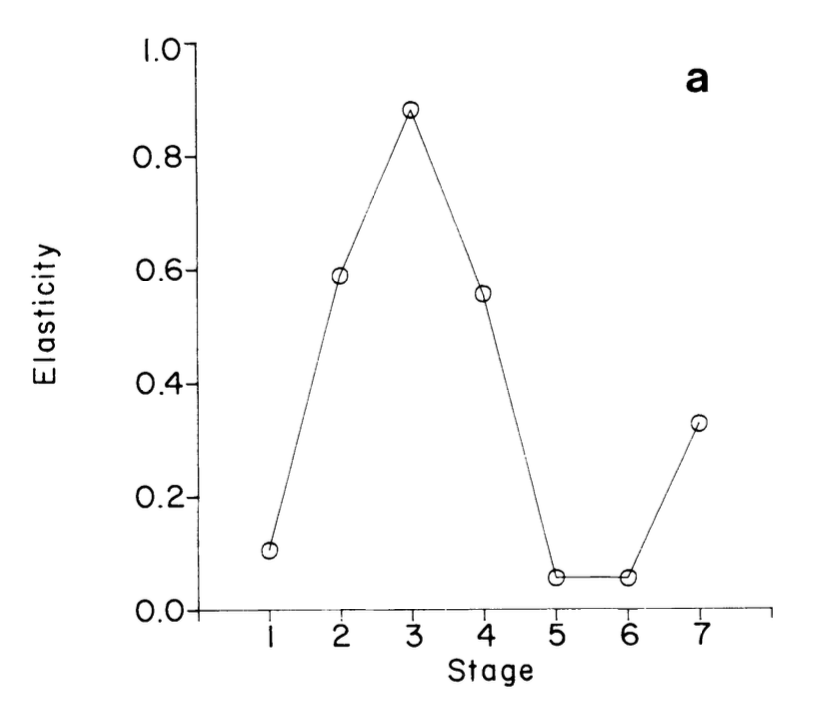

(Figure 4a: eigenvalue elasticity with respect to $p_i$.)

#### Management strategy: TEDs

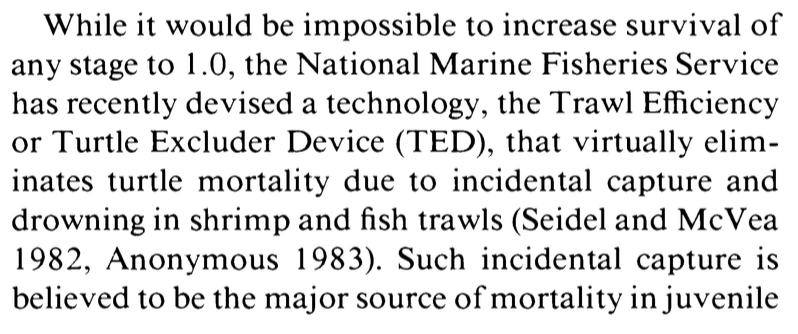

In terms of model: effects one-year survival probability of different stages (Table 6).

##### Scenario 1: TEDs increase one-year survival of immature turtles (stages 2-4) to 0.8

In [43]:
p_pert = p = np.array([0.6747,0.8,0.8,0.8,0.8091,0.8091,0.8091])
P_pert = np.zeros(7)
G_pert = np.zeros(6)

In [44]:
for i in range(7):
    gamma = (p_pert[i]**(d[i]-1))*(1-p_pert[i])/(1-p_pert[i]**d[i])
    if i < 6:
        G_pert[i] = p_pert[i]*gamma
    P_pert[i] = p_pert[i]*(1-gamma)

A_pert = np.zeros((7,7))
A_pert[0,1:7] = F[1:7] # F_2, F_3, ... F_7
A_pert[np.diag_indices_from(A_pert)] = P_pert # set main diagonal as elements of P
# set the -1 offset diagonal as elements of G
for j in range(6):
    A_pert[j+1,j] = G_pert[j]

np.set_printoptions(precision=4,suppress=True)
print(A_pert)

[[  0.       0.       0.       0.     127.       4.      80.    ]
 [  0.6747   0.7469   0.       0.       0.       0.       0.    ]
 [  0.       0.0531   0.7597   0.       0.       0.       0.    ]
 [  0.       0.       0.0403   0.7289   0.       0.       0.    ]
 [  0.       0.       0.       0.0711   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.8091   0.       0.    ]
 [  0.       0.       0.       0.       0.       0.8091   0.8088]]


In [45]:
l,v = la.eig(A_pert)
idx=np.argsort(np.abs(l))
l_sorted=l[idx]  
print('lambda_max=', l_sorted[-1])

lambda_max= (1.0570704352555196+0j)


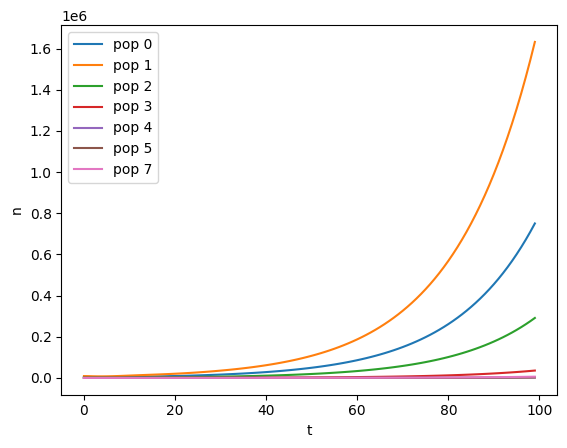

In [46]:
Tmax=100
n_vs_t=np.zeros([7,Tmax])
n_zero=np.array([2900,9000,1600,100,5,4,20])
n_vs_t[:,0]=n_zero 

for t in np.arange(Tmax-1):
    n_vs_t[:,t+1]=np.dot(A_pert,n_vs_t[:,t])

    generation_arr=np.arange(Tmax)

plt.plot(generation_arr,n_vs_t[0,:],label="pop 0")
plt.plot(generation_arr,n_vs_t[1,:],label="pop 1")
plt.plot(generation_arr,n_vs_t[2,:],label="pop 2")
plt.plot(generation_arr,n_vs_t[3,:],label="pop 3")
plt.plot(generation_arr,n_vs_t[4,:],label="pop 4")
plt.plot(generation_arr,n_vs_t[5,:],label="pop 5")
plt.plot(generation_arr,n_vs_t[6,:],label="pop 7")
plt.xlabel('t')
plt.ylabel('n')
plt.legend()

#### Breakouts: 15 minutes

Repeat this process (i.e., compute new matrix `A_pert`, find dominant eigenvalue, iterate model forward and plot) for remaining two scenarios from Crouse et al:
1. Increase large juvenile (stage 3) and subadult (stage 4) one-year survival probability to 0.8 and increase all adult (stages 5-7) one-year survival probabilities to 0.85.
2. Same as above scenario, but also <i>decrease</i> first-year (stage 1) survival by 50%

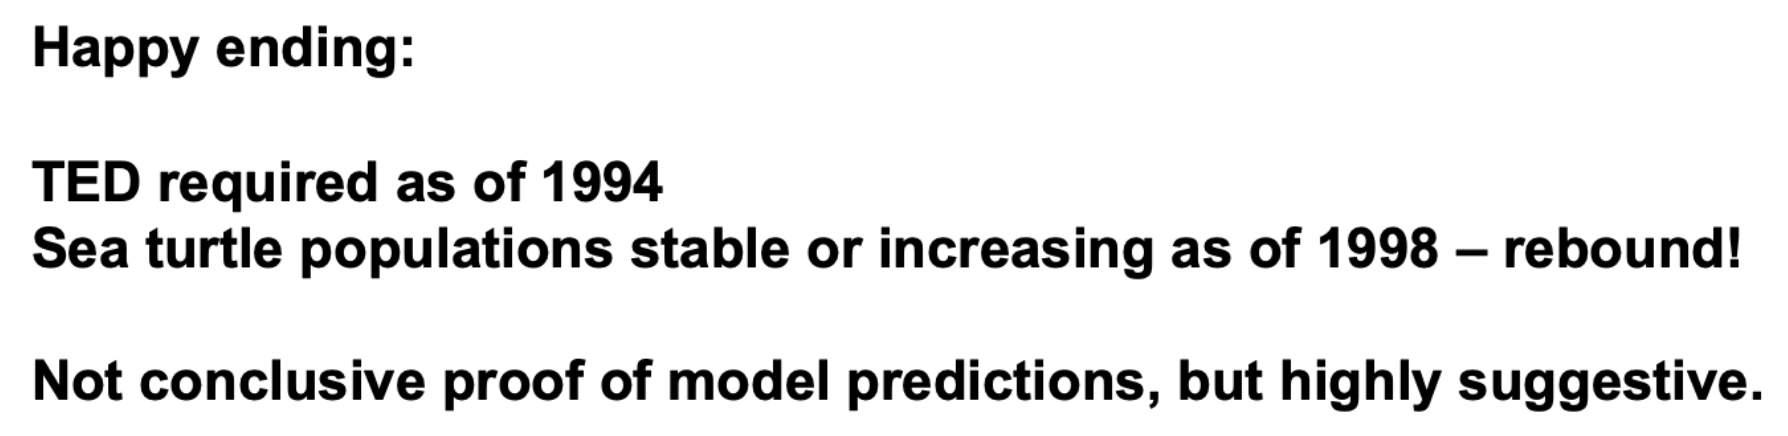